In [1]:
import cupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.math.toccd import toccd

from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer

from  ekarus.e2e.utils.image_utils import get_photocenter, get_circular_mask, image_grid, reshape_on_mask


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator

def create_field_from_zernike_coefficients(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase = project_zernike_on_mask(mask, noll_ids, amplitudes)
    amp = xp.asarray(mask.asTransmissionValue())
    return  amp * xp.exp(1j * phase)


def project_zernike_on_mask(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    zg = ZernikeGenerator(mask)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(noll))
    else:
        amplitudes *= xp.ones(len(noll_ids))
        zern = xp.zeros(mask.mask().shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(noll))

    return zern

In [3]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.asnumpy(xp.log(image[roi[0]: roi[1], roi[0]:roi[1]]))
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

def tilt_field(pyr, field, tiltAmpX, tiltAmpY):
    tiltX,tiltY = pyr._get_XY_tilt_planes(field.shape)
    wedge_tilt = (tiltX*tiltAmpX + tiltY*tiltAmpY)*(2*xp.pi)#*pyr.oversampling
    focal_plane_field = xp.fft.fftshift(xp.fft.fft2(field))
    field = focal_plane_field * xp.exp(1j*wedge_tilt)#, dtype=pyr.cdtype)
    field = xp.fft.ifft2(xp.fft.ifftshift(field))
    return field

(np.float64(288.0), np.float64(352.0), np.float64(288.0), np.float64(352.0))

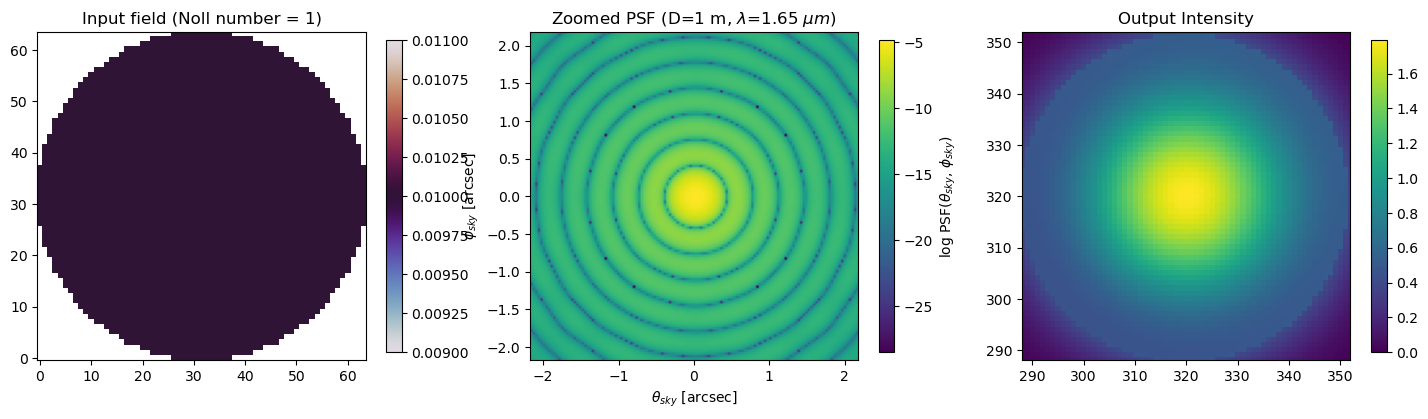

In [4]:
Npix = 64

dotInLambdaOverD = 2
dotDelay = xp.pi/2

# Create pupil mask
oversampling = 10
mask = CircularMask((Npix,Npix), maskRadius=Npix / 2)

# Conversions
pupilDiameterInM = 1
lambdaInM = 1650e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec
lambdaOverD = lambdaInM/pupilDiameterInM

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 0.01
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Electric field propagation
padded_field = xp.pad(input_field, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))

zwfs_mask = CircularMask((Npix*oversampling,Npix*oversampling), maskRadius=oversampling*dotInLambdaOverD/2)
zwfs_delay = xp.asarray(dotDelay*(1.0-zwfs_mask.mask()))
zwfs_amp = 1.0 - (1.0 - xp.exp(1j*zwfs_delay,dtype=xp.complex64))*xp.asarray(zwfs_mask.asTransmissionValue())

# delayed_field = fp_field * xp.exp(1j*zwfs_delay,dtype=xp.complex64)
delayed_field = fp_field * zwfs_amp
output_field = xp.fft.ifft2(xp.fft.ifftshift(delayed_field))
intensity = xp.abs(output_field**2)

# Compute normalized psf
psf = xp.abs(xp.abs(fp_field**2))
psf *= 1/xp.sum(psf)

# Plotting results
s = 0.45
plt.figure(1, figsize=(18,9))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(masked_array(xp.asnumpy(xp.angle(input_field)),mask=mask.mask()), cmap='twilight', origin='lower')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)


plt.subplot(1, 3, 3)
plt.title("Output Intensity")
plt.imshow(xp.asnumpy(intensity),origin='lower')
plt.colorbar(shrink=s)
plt.axis([Npix/2*(oversampling-1),Npix/2*(oversampling+1),Npix/2*(oversampling-1),Npix/2*(oversampling+1)])

# plt.figure()
# plt.imshow(xp.asnumpy(zwfs_delay),origin='lower',cmap='twilight')
# plt.colorbar()

320.4343356130265 320.4343356130266


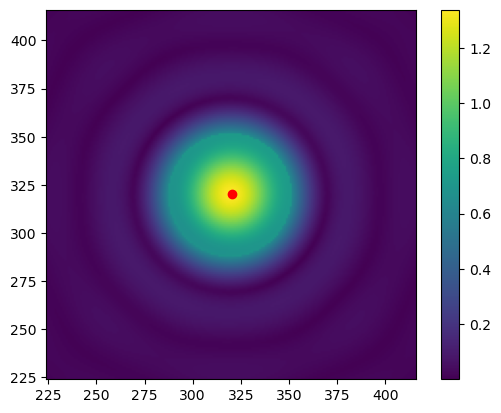

In [5]:
qx,qy = get_photocenter(intensity)

plt.figure()
plt.imshow(xp.asnumpy(xp.abs(output_field)),origin='lower')
plt.colorbar()
plt.axis([Npix/2*(oversampling-3),Npix/2*(oversampling+3),Npix/2*(oversampling-3),Npix/2*(oversampling+3)])
plt.scatter(xp.asnumpy(qx),xp.asnumpy(qy),c='red')

print(qx,qy)

In [6]:

roi_mask = CircularMask((Npix*oversampling,Npix*oversampling), maskRadius=Npix/2)
roi_mask = xp.asarray(roi_mask.mask())

def get_slope(input_field, oversampling):
    padded_field = xp.pad(input_field, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
    fp_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
    delayed_field = fp_field * zwfs_amp
    output_field = xp.fft.ifft2(xp.fft.ifftshift(delayed_field))
    intensity = xp.abs(output_field**2)
    slope = intensity[~roi_mask]
    return slope,intensity

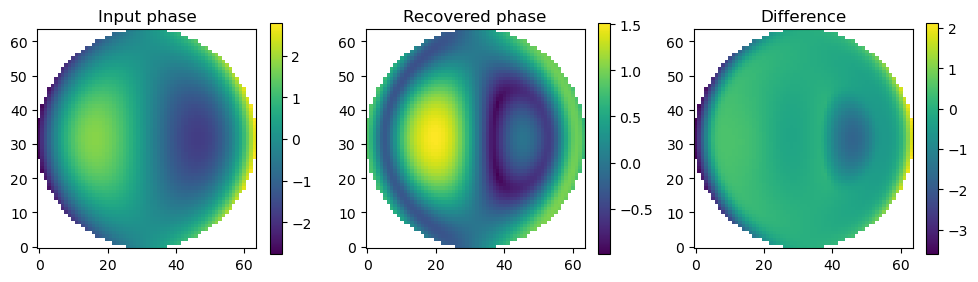

In [7]:
noll = 8
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

slope, intensity = get_slope(input_field,oversampling=oversampling)

phi = xp.sqrt(2*slope)-1
rec_phase = reshape_on_mask(phi,mask.mask())

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title("Input phase")
plt.imshow(masked_array(xp.asnumpy(xp.angle(input_field)),mask=mask.mask()),origin='lower')
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Recovered phase")
plt.imshow(masked_array(xp.asnumpy(rec_phase),mask=mask.mask()),origin='lower')
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow(masked_array(xp.asnumpy(xp.angle(input_field)-rec_phase),mask=mask.mask()),origin='lower')
plt.colorbar()

In [8]:
# Compute slopes for Zernike modes
N = 9
Nmodes = (N-1)*(N-2)//2
IM = xp.zeros((int(xp.size(slope)),Nmodes))

zern_amp = 2e-3
N0 = 2

for i in range(Nmodes):

    noll = N0 + i
    input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)
    zern_slope,_ = get_slope(input_zern,oversampling=oversampling)

    IM[:,i] = zern_slope/zern_amp

U,S,V = xp.linalg.svd(IM, full_matrices=False)

Sinv = 1/S
Rec = (V.T * Sinv) @ U.T

Text(0.5, 1.0, 'Measured intensity')

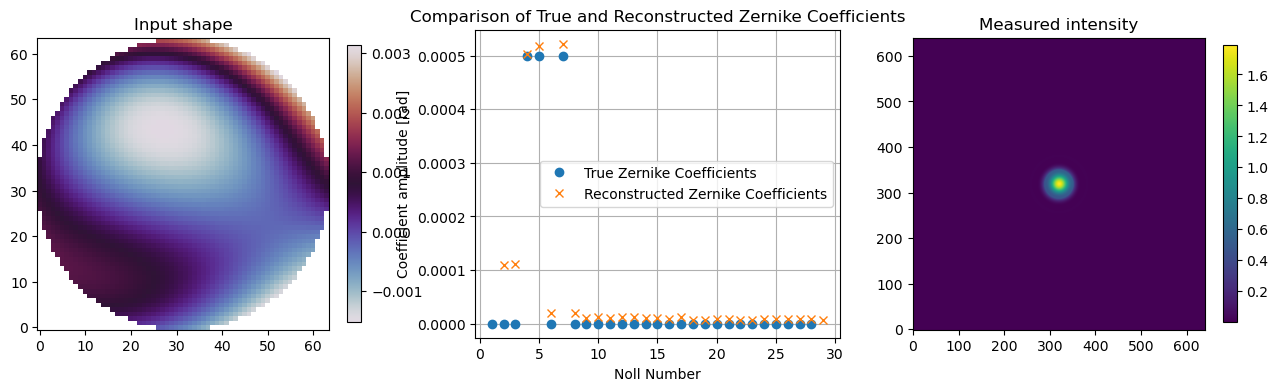

In [9]:
# Test the reconstructor
zids = (4,5,7)
zamps = 5e-4
zern_mix = create_field_from_zernike_coefficients(mask, zids, zamps)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(xp.angle(zern_mix)),mask=mask.mask()), cmap='twilight',origin='lower')
plt.colorbar(shrink=0.9)
plt.title('Input shape')

# Propagate the field through the WFS
# output_field = wfs.propagate(zern_mix/pix2rad)
# output_intensity = xp.abs(output_field**2)

# Compute slopes
slope,intensity = get_slope(zern_mix,oversampling=oversampling)

# Reconstruct the Zernike coefficients
zern_reconstructed = Rec @ slope
rec_noll_ids = xp.arange(Nmodes)+N0

noll_ids = xp.arange(Nmodes)+1
true_zern = xp.zeros(Nmodes)
true_zern[xp.array(zids)-1] = zamps

plt.subplot(1,3,2)
plt.plot(xp.asnumpy(noll_ids), xp.asnumpy(true_zern), 'o', label='True Zernike Coefficients')
plt.plot(xp.asnumpy(rec_noll_ids), xp.asnumpy(zern_reconstructed), 'x', label='Reconstructed Zernike Coefficients')
plt.xlabel('Noll Number')
plt.ylabel('Coefficient amplitude [rad]')
plt.title('Comparison of True and Reconstructed Zernike Coefficients')
plt.legend(loc='best')
plt.grid()

plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(intensity),origin='lower')
plt.colorbar(shrink=0.9)
plt.title('Measured intensity')

In [10]:
def push_pull_calibrate(Nmodes, amp:float = 0.02):
    
    slope_len = len(slope)
    IM = xp.zeros((slope_len,Nmodes))

    for i in range(Nmodes):

        noll = 2 + i

        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        push_slope,_ = get_slope(input_zern,oversampling)
        pull_slope,_ = get_slope(xp.conj(input_zern),oversampling)

        if noll <= 16:
            plt.figure(figsize=(18,5))
            plt.subplot(1,3,1)
            plt.plot(xp.asnumpy(push_slope/amp))
            plt.grid()
            plt.subplot(1,3,2)
            plt.plot(xp.asnumpy(pull_slope/amp))
            plt.title(f'Noll {noll}')
            plt.grid()
            plt.subplot(1,3,3)
            plt.plot(xp.asnumpy((push_slope-pull_slope)/(2*amp)))
            plt.grid()

        IM[:,i] = (push_slope-pull_slope)/(2*amp)

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

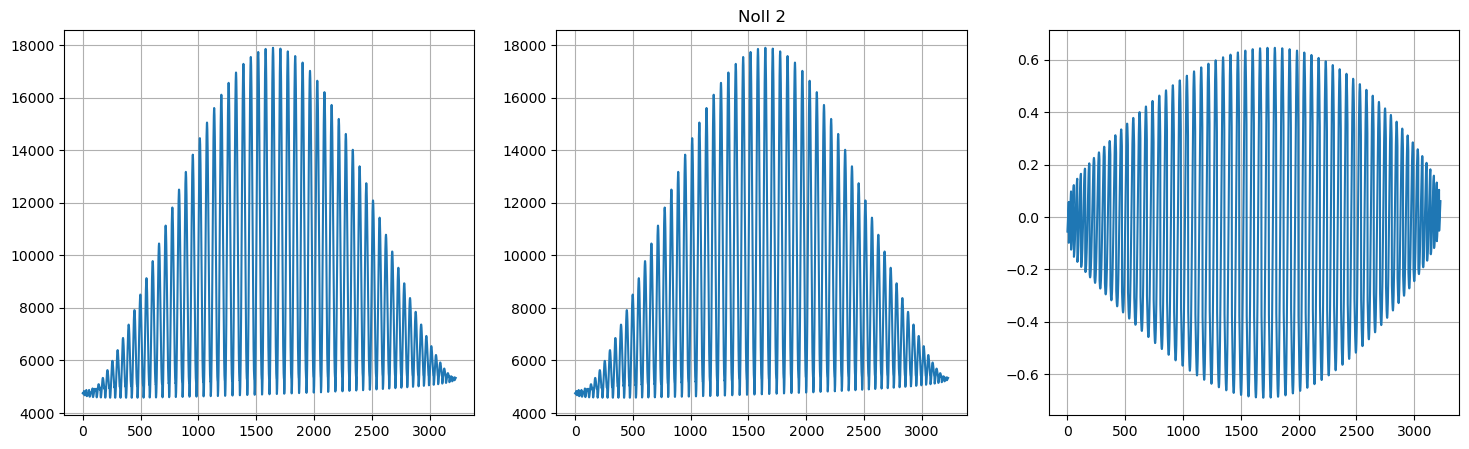

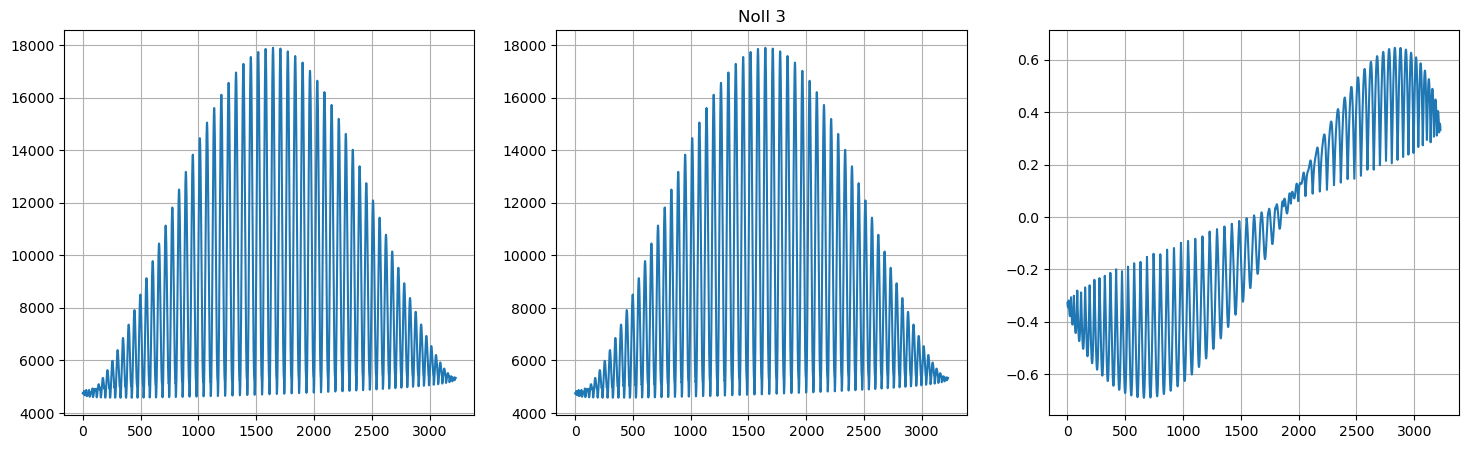

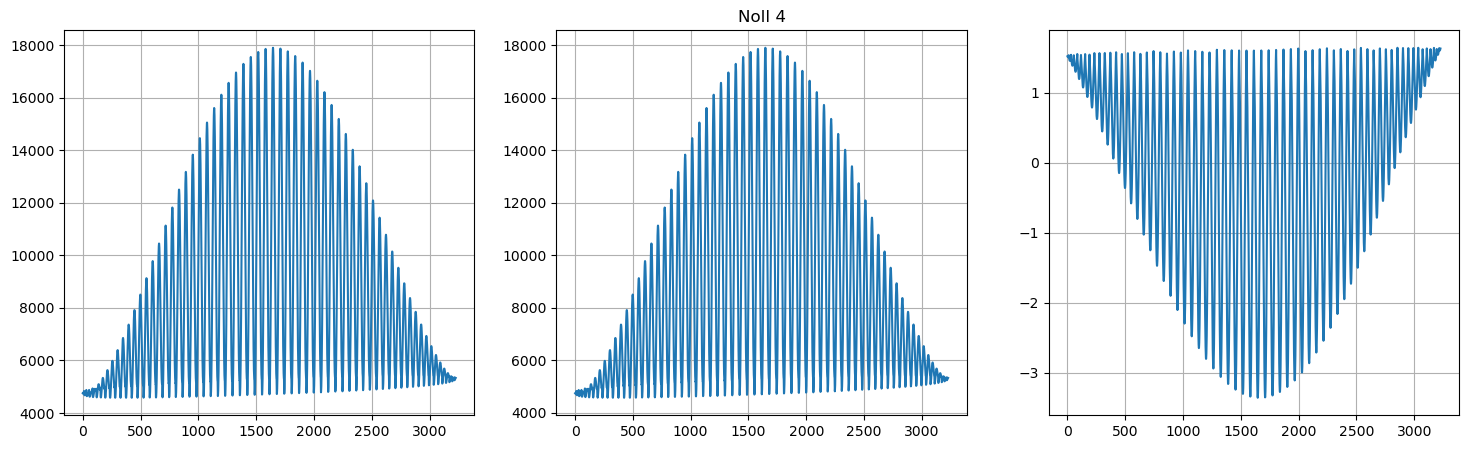

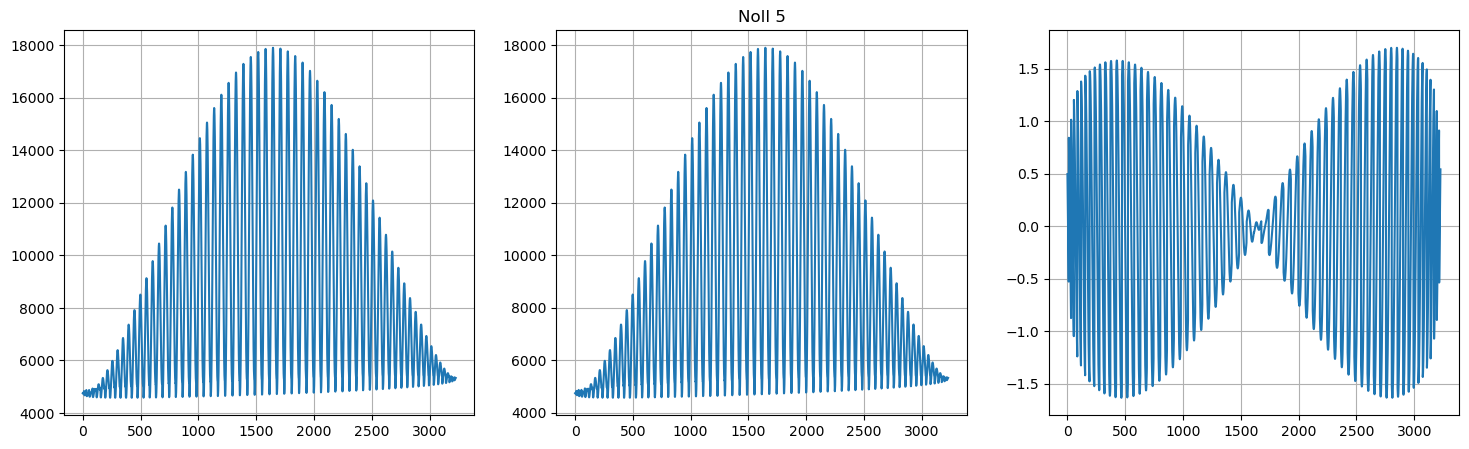

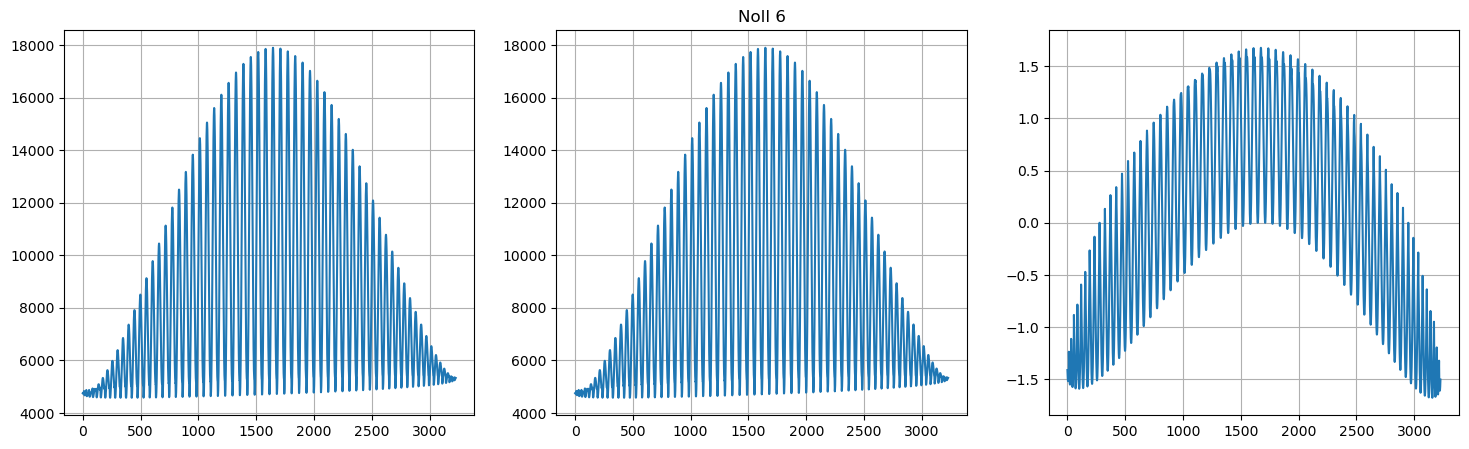

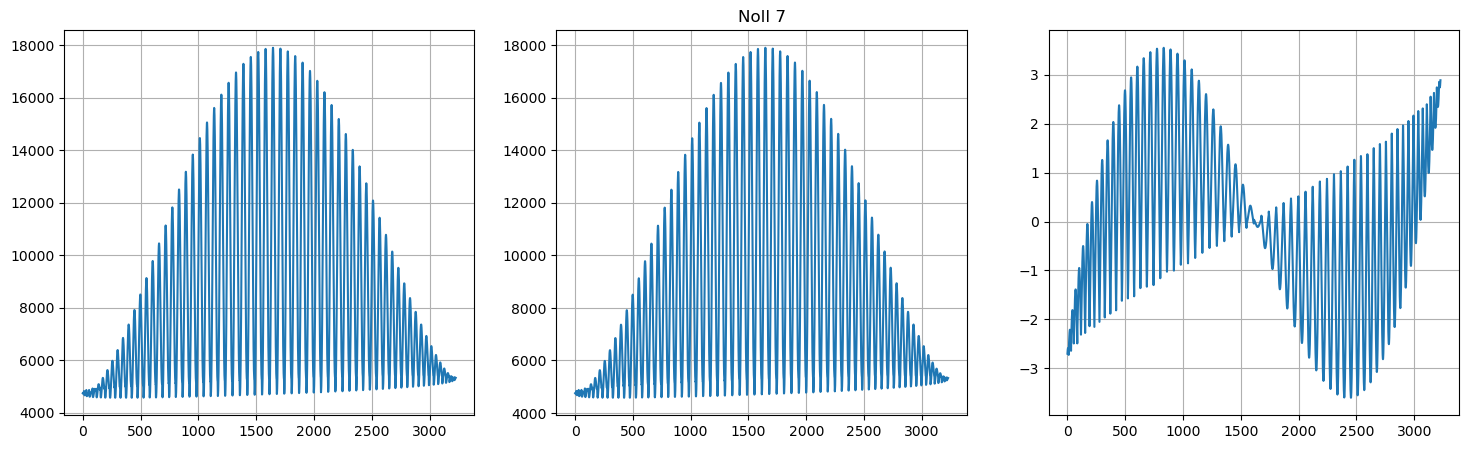

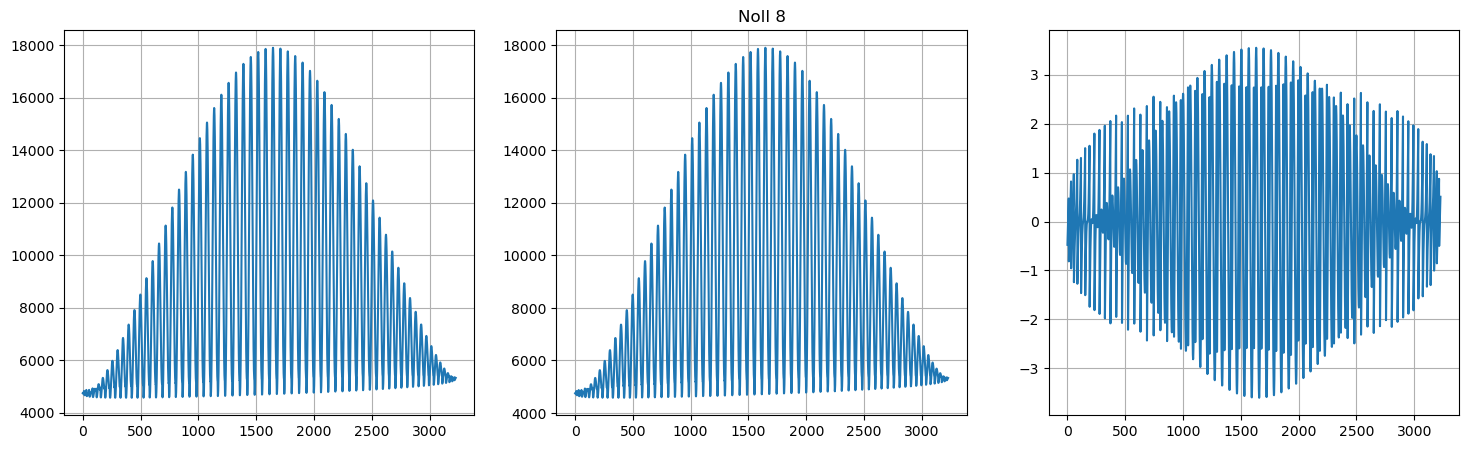

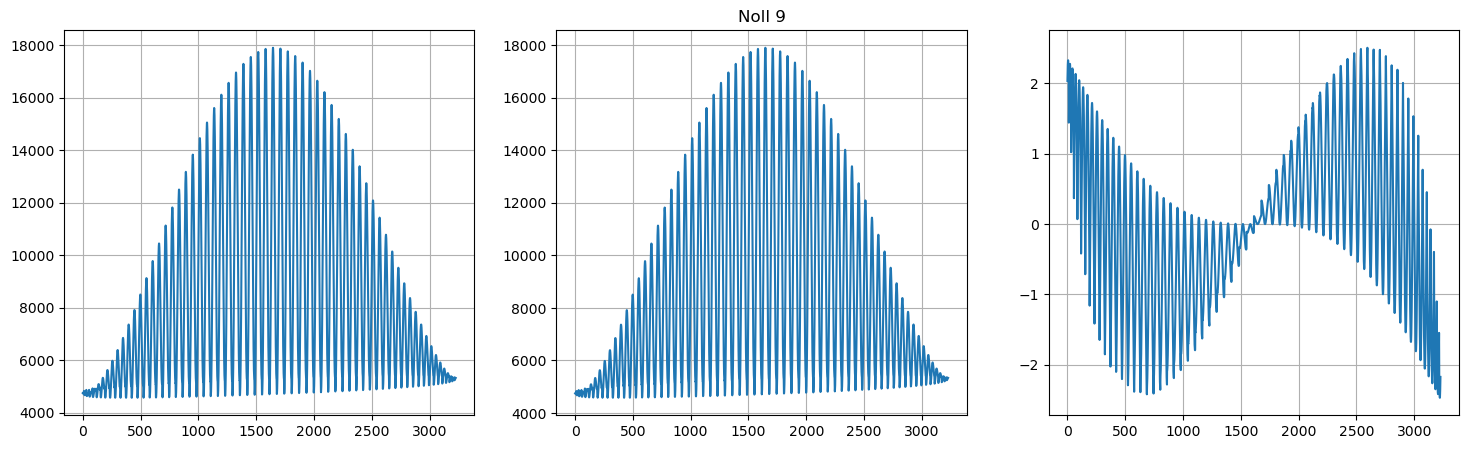

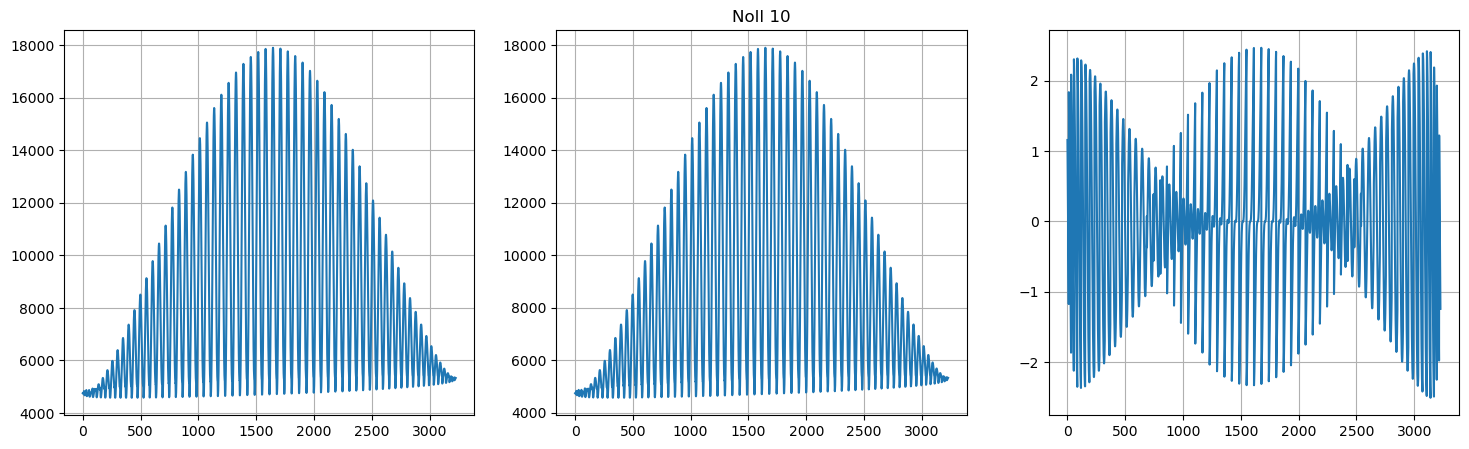

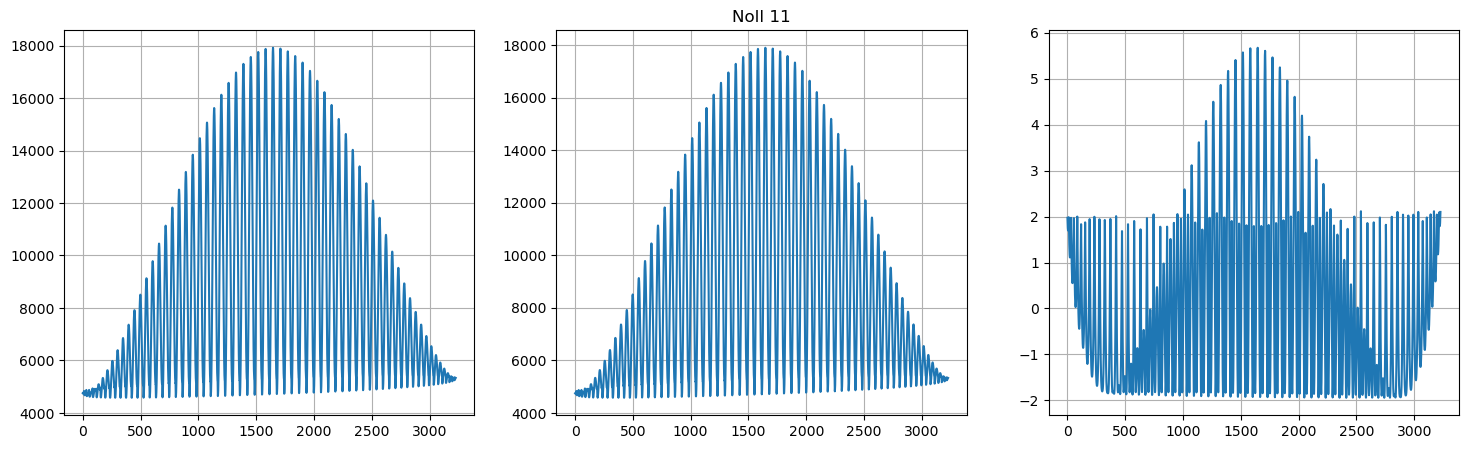

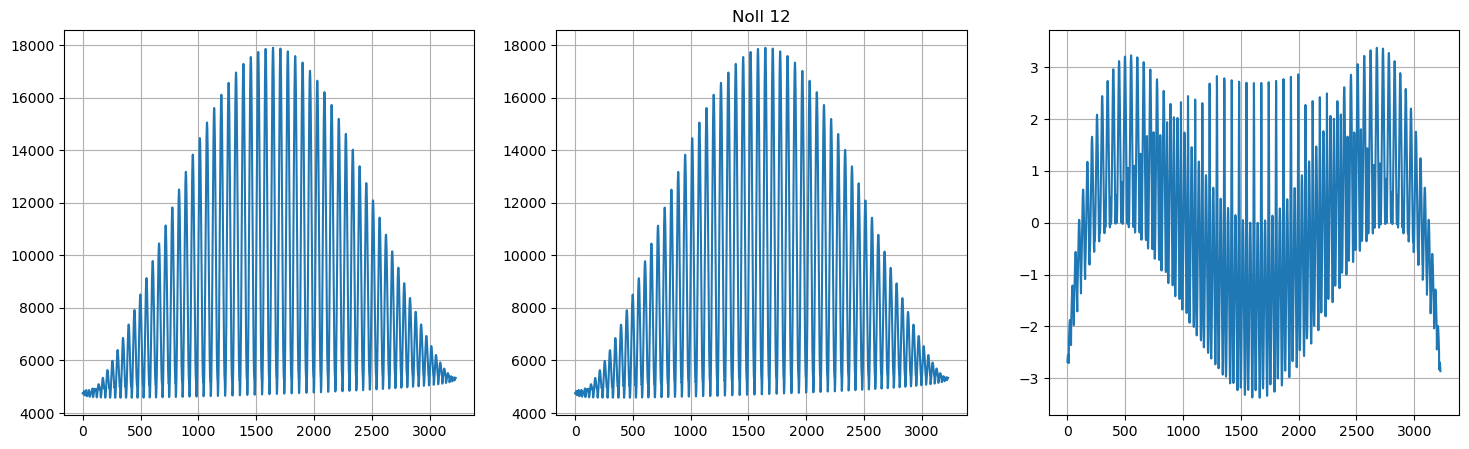

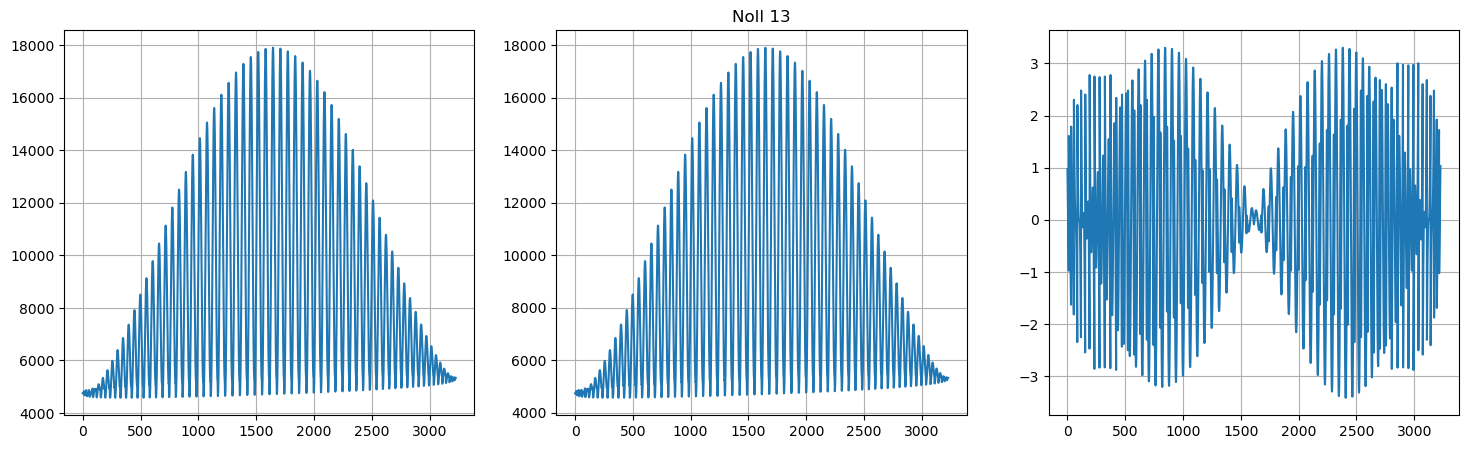

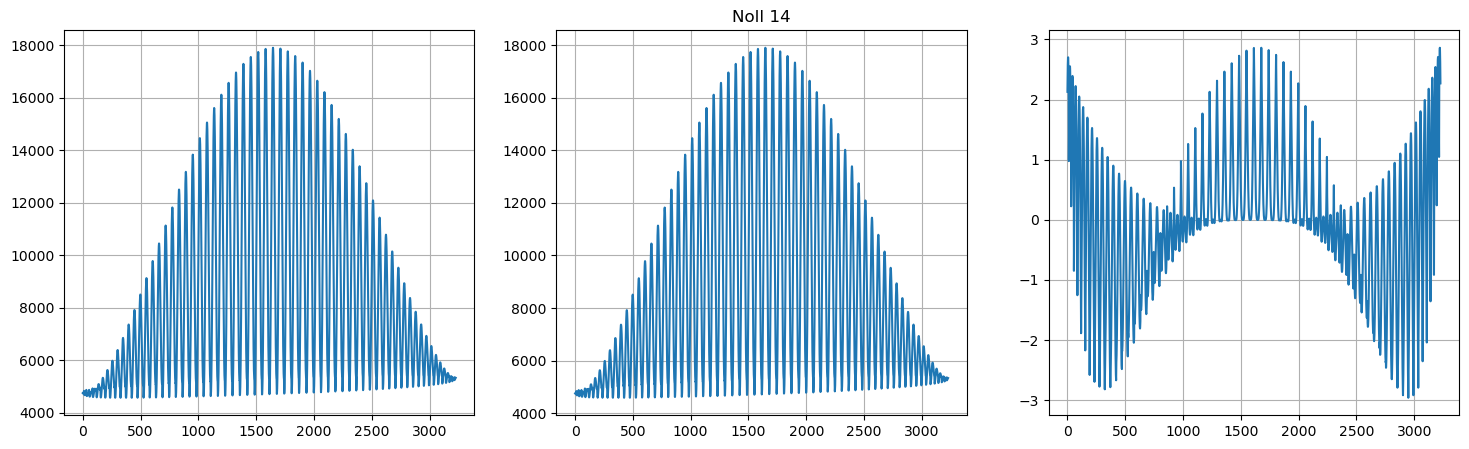

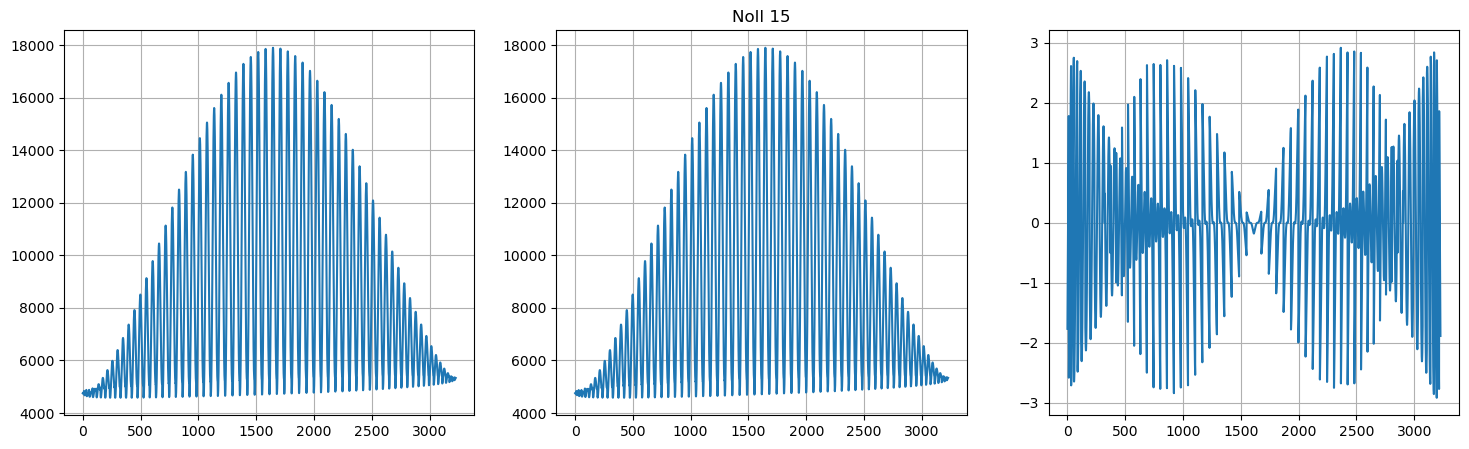

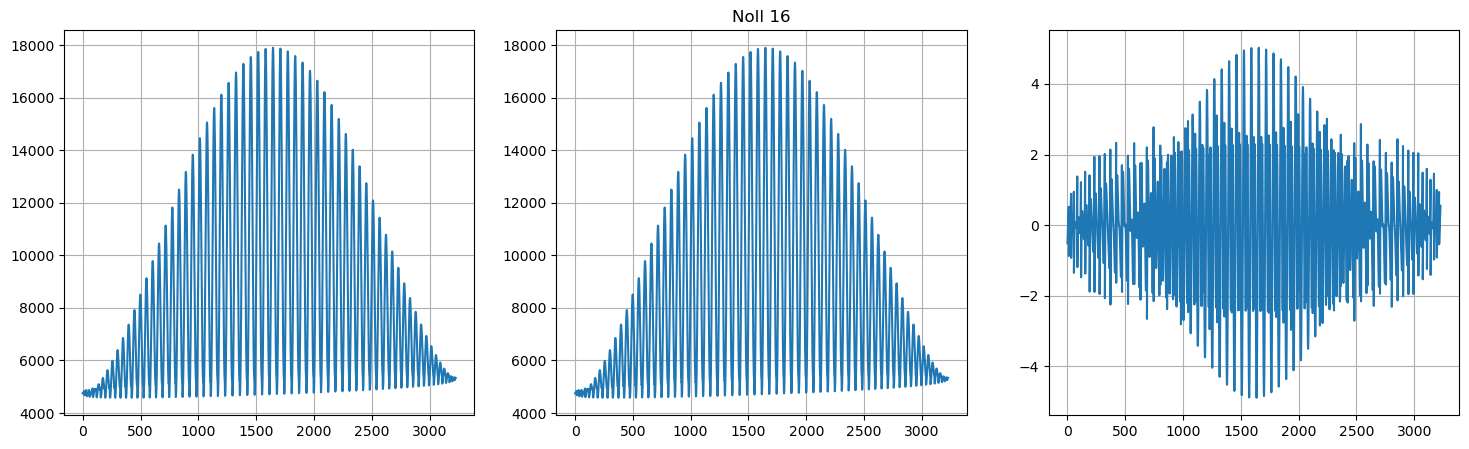

In [11]:
N = 7
nRecModes = int((N+1)*N/2)

RecPP,IMpp = push_pull_calibrate(nRecModes,amp=1e-4)

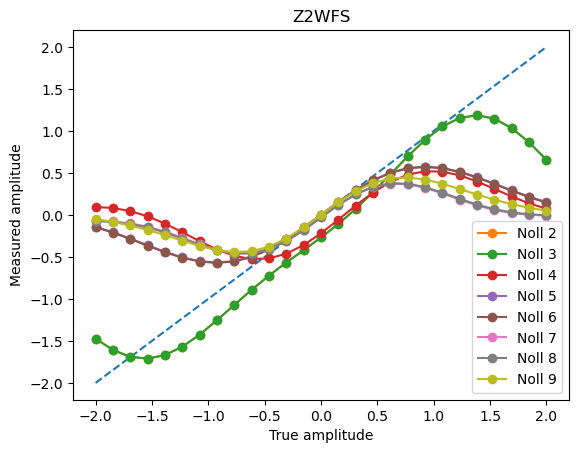

In [12]:
# Linearity check (low modes)
Nmodes = 8
amp_vec = xp.linspace(-2,2,27,endpoint=True)

plt.figure()
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        slopes,_ = get_slope(zern, oversampling)
        zern_reconstructed = RecPP @ slopes
        meas_amp[k] = zern_reconstructed[zid-2]

    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title('Z2WFS')
    plt.grid()

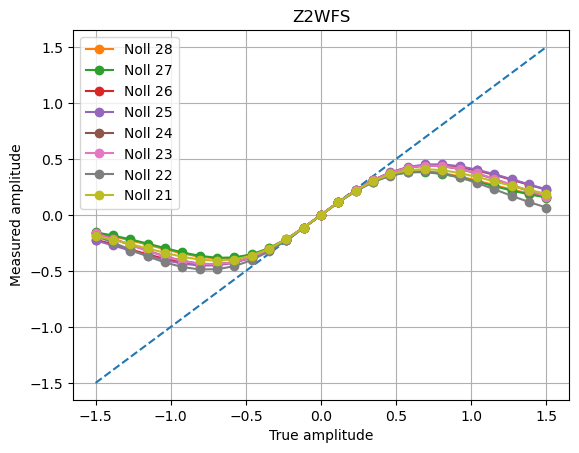

In [13]:
# Linearity check (high modes)
Nmodes = 8
amp_vec = xp.linspace(-1.5,1.5,27,endpoint=True)

plt.figure()
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')

for j in range(Nmodes):

    zid = nRecModes-j
    meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        slopes,_ = get_slope(zern, oversampling)
        zern_reconstructed = RecPP @ slopes
        meas_amp[k] = zern_reconstructed[zid-2]

    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title('Z2WFS')
    plt.grid(True)